In [1]:
from PIL import Image
import glob
import numpy as np

files = glob.glob("resources/*.png")
tensor_arr = []

for file in files:
    im = Image.open(file)
    tensor_arr.append(np.array(im))

In [2]:
train_tensors_f = tensor_arr[0:512]
train_tensors_g = tensor_arr[512:1024]
test_tensors = tensor_arr[1024:(1024+256)]

In [3]:
from transfer_em.datasets import datasets
from transfer_em import debug
import tensorflow as tf
#tf.config.experimental_run_functions_eagerly(True)

In [4]:
# create training input and output (input is warped automatically)
train_f, meanstd_f = datasets.create_dataset_from_tensors(train_tensors_f, custom_map=debug.warp_tensor)
train_g, meanstd_g = datasets.create_dataset_from_tensors(train_tensors_g)

In [5]:
# create a test set for evaluation
# disable augmentation and random shuffling; test input should be warped
test_dataset, d1 = datasets.create_dataset_from_tensors(test_tensors, custom_map=debug.warp_tensor, meanstd=meanstd_f, enable_augmentation=False, randomize=False)
test_dataset_gt, d1 = datasets.create_dataset_from_tensors(test_tensors, meanstd=meanstd_g, enable_augmentation=False, randomize=False)

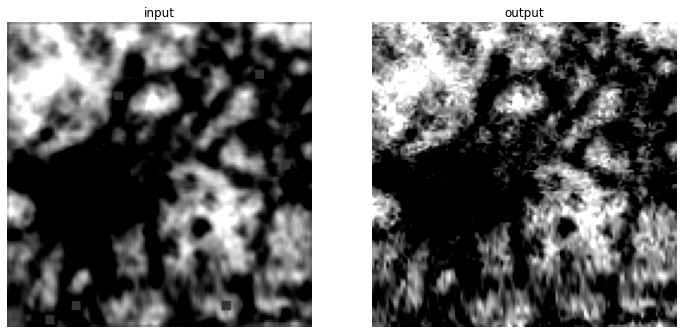

In [6]:
# get a sample from the test dataset and view
sample = next(iter(test_dataset))
sample_gt = next(iter(test_dataset_gt))
from transfer_em.debug import generate_images
generate_images(sample, sample_gt)

In [7]:
# create EM2EM network with 128x128 image and provide an experiment name for checkpointing
from transfer_em.cgan import EM2EM
em2em = EM2EM(128, "example2d", is3d=False)

Accuracy on sample: 0.5963172912597656


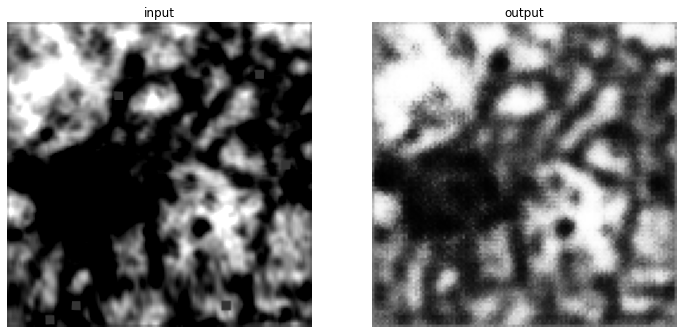

Time taken for epoch 5 is 75.86090588569641


In [8]:
# train for 5 EPOCHS
em2em.train(train_f, train_g, 5, 0, True, sample, sample_gt, num_samples=512//64)

In [9]:
# run prediction on the sample (64 image batch)
sample_pred = em2em.predict(sample)

# rescale based on f's meanstd
sample_unstd = datasets.unstandardize_population(sample, meanstd_f)

# rescale prediction based on g's meanstd
sample_pred_unstd = datasets.unstandardize_population(sample_pred, meanstd_g)

# view final results
generate_images(sample_unstd, sample_pred_unstd)

# view accuracy using RMSE for first image
print(debug.accuracy(sample_gt, sample_pred))

NameError: name 'dataset' is not defined